In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-02 23:13:12--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.2’

CreditScoring.csv.2 100%[===================>] 178,21K  1,09MB/s    in 0,2s    

2021-10-02 23:13:13 (1,09 MB/s) - ‘CreditScoring.csv.2’ saved [182489/182489]



In [7]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

In [8]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [9]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

In [10]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [11]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

In [12]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

In [13]:
df.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


In [14]:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int64
dtype: object

In [15]:
categorical = list(df.select_dtypes ('object'))
categorical 

['home', 'marital', 'records', 'job']

In [16]:
categorical = ['home', 'marital', 'records', 'job']

In [17]:
numerical = list(df.select_dtypes('int64'))
numerical


['seniority',
 'time',
 'age',
 'expenses',
 'income',
 'assets',
 'debt',
 'amount',
 'price',
 'default']

In [18]:
numerical = ['seniority',
 'time',
 'age',
 'expenses',
 'income',
 'assets',
 'debt',
 'amount',
 'price']

Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the "default" variable
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenses'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

seniority
time
income
debt

In [19]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc 

In [20]:
for variable in numerical:
    fpr, tpr, thresholds = roc_curve(y_train, df_train[variable].values)
    auc_score = auc(fpr, tpr)
    
    if auc_score < 0.5:
        fpr, tpr, thresholds = roc_curve(y_train, -df_train[variable].values)
        auc_score = auc(fpr, tpr)
    
    print(f'{variable} variable has a auc score of: {auc_score}')

seniority variable has a auc score of: 0.7093778624491943
time variable has a auc score of: 0.5608662489595051
age variable has a auc score of: 0.5732933272499939
expenses variable has a auc score of: 0.5009184217217011
income variable has a auc score of: 0.682006666132633
assets variable has a auc score of: 0.6486042567122802
debt variable has a auc score of: 0.5047829675783548
amount variable has a auc score of: 0.5910773431595518
price variable has a auc score of: 0.5043329862114843


##Training the model

From now on, use these columns only:

['seniority', 'income', 'assets', 'records', 'job', 'home']
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [21]:
features = ['seniority', 'income', 'assets', 'records', 'job', 'home']

dv = DictVectorizer(sparse=False)
train_dict = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[features].to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

In [22]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [23]:
y_pred = model.predict_proba(X_val)[:,1]
y_pred

array([1.96864517e-01, 1.17566830e-01, 2.69816999e-01, 1.23272297e-01,
       4.14163558e-02, 6.03395041e-01, 8.47303706e-01, 2.30826676e-01,
       9.20153615e-01, 3.40257142e-01, 3.19613906e-01, 6.28633454e-02,
       4.05811355e-01, 4.06879435e-01, 1.01941492e-01, 7.06995810e-02,
       3.02017778e-02, 2.74911652e-01, 7.92665974e-01, 5.23975117e-02,
       4.90721608e-01, 1.33304655e-01, 7.04819954e-02, 1.78498677e-02,
       4.18153981e-01, 5.33852022e-01, 5.31608722e-01, 1.02859300e-01,
       4.30786409e-01, 2.42859212e-02, 2.25436210e-01, 4.93559876e-02,
       3.15443702e-01, 1.23846910e-01, 6.97466123e-01, 8.41046084e-02,
       5.28890028e-02, 6.76631141e-01, 1.11294087e-01, 1.21434239e-01,
       3.95982795e-01, 1.00225341e-01, 1.12215164e-01, 1.76622050e-01,
       1.22913696e-01, 5.37205476e-01, 7.96489211e-01, 6.94633964e-01,
       6.10214554e-02, 2.27408800e-02, 3.36416888e-01, 1.06107907e-01,
       8.43867781e-02, 5.33933185e-01, 1.53052162e-01, 5.56195627e-01,
      

In [24]:
roc_auc_score(y_val, y_pred)
# print('AUC of this model on the validation dataset is:', roc_auc_score)
# print(f'AUC of this model on the validation dataset is: {roc_auc_score}')
print("AUC of this model on the validation dataset : %s" % round(roc_auc_score(y_val, y_pred), 3))

AUC of this model on the validation dataset : 0.812


Question 3

Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

In [25]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (actual_negative & predict_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    scores.append((t, tp, fp, fn, tn, precision, recall))

/var/folders/j2/5gq4v31n7xj5qlln62tlhzxw0000gn/T/ipykernel_1082/3971591322.py:18: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


In [26]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

Text(0, 0.5, 'Values')

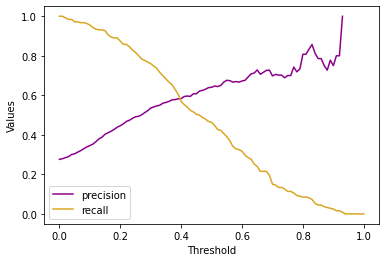

In [27]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision', color='darkmagenta')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall', color='goldenrod')
plt.legend()

plt.xlabel('Threshold')
plt.ylabel('Values')

Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [28]:
df_scores['F1'] = (2*df_scores['precision'] * df_scores['recall']) / (df_scores['precision'] + df_scores['recall'])

df_scores[df_scores['F1'] == df_scores.F1.max()]

,threshold,tp,fp,fn,tn,precision,recall,F1
30,0.3,187,162,59,483,0.535817,0.760163,0.628571


Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard devidation of the AUC scores across different folds?

In [40]:
def train(df_train, y_train, c=1.0):
    dicts = df_train.to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [41]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')
    
    X = dv.transform(dicts)    
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [31]:
from sklearn.model_selection import KFold

In [42]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [47]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train[features], y_train)
    y_pred = predict(df_val[features], dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f'{np.mean(scores):.4f} +- {np.std(scores):.4f}')

0.8142 +- 0.0146


Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 1, 10]
Initialize KFold with the same parameters as previously
Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

0.01
0.1
1
10
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [55]:
n_splits = 5

for C in [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train[features], y_train, c=C)
        y_pred = predict(df_val[features], dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.808 +- 0.012
C=0.1 0.813 +- 0.014
C=1 0.814 +- 0.015
C=10 0.814 +- 0.015
